<a href="https://colab.research.google.com/github/WyattRoss/csci4170/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', output_activation='softmax', learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation = activation
        self.output_activation = output_activation
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = []
        self.biases = []

        for i in range(self.num_layers - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _sigmoid(self, x):
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        s = self._sigmoid(x)
        return s * (1 - s)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def _softmax(self, x):
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def _linear(self, x):
        return x

    def _get_activation_function(self, activation_name):
        if activation_name == 'relu':
            return self._relu
        elif activation_name == 'sigmoid':
            return self._sigmoid
        elif activation_name == 'tanh':
            return self._tanh
        elif activation_name == 'softmax':
            return self._softmax
        elif activation_name == 'linear':
            return self._linear
        else:
            raise ValueError(f"Unknown activation function: {activation_name}")

    def _get_activation_derivative(self, activation_name):
        if activation_name == 'relu':
            return self._relu_derivative
        elif activation_name == 'sigmoid':
            return self._sigmoid_derivative
        elif activation_name == 'tanh':
            return self._tanh_derivative
        else:
            raise ValueError(f"No derivative implemented for: {activation_name}")

    def forward_propagation(self, X):
        batch_size = X.shape[0]

        # Store activations and pre-activations
        activations = [X]  # Input layer activation
        pre_activations = []  # Pre-activation values (z = Wx + b)

        current_input = X

        # Forward pass through hidden layers
        for i in range(self.num_layers - 2):  # All layers except output
            z = np.dot(current_input, self.weights[i]) + self.biases[i]
            pre_activations.append(z)

            activation_func = self._get_activation_function(self.activation)
            a = activation_func(z)
            activations.append(a)
            current_input = a

        # Output layer
        z_output = np.dot(current_input, self.weights[-1]) + self.biases[-1]
        pre_activations.append(z_output)

        output_activation_func = self._get_activation_function(self.output_activation)
        a_output = output_activation_func(z_output)
        activations.append(a_output)

        return {
            'activations': activations,
            'pre_activations': pre_activations
        }

    def backward_propagation(self, X, y, forward_cache):
        batch_size = X.shape[0]
        activations = forward_cache['activations']
        pre_activations = forward_cache['pre_activations']

        # Initialize gradients
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]

        # Output layer error
        if self.output_activation == 'softmax':
            # For softmax with cross-entropy loss
            dz = activations[-1] - y
        else:
            # For other activation functions
            dz = activations[-1] - y
            if self.output_activation != 'linear':
                activation_derivative = self._get_activation_derivative(self.output_activation)
                dz *= activation_derivative(pre_activations[-1])

        # Gradients for output layer
        dW[-1] = np.dot(activations[-2].T, dz) / batch_size
        db[-1] = np.mean(dz, axis=0, keepdims=True)

        # Backpropagate through hidden layers
        for i in range(self.num_layers - 3, -1, -1):  # From second-to-last to first hidden layer
            # Compute error for current layer
            dz = np.dot(dz, self.weights[i + 1].T)

            # Apply activation derivative
            activation_derivative = self._get_activation_derivative(self.activation)
            dz *= activation_derivative(pre_activations[i])

            # Compute gradients
            dW[i] = np.dot(activations[i].T, dz) / batch_size
            db[i] = np.mean(dz, axis=0, keepdims=True)

        return {'dW': dW, 'db': db}

    def compute_loss(self, y_true, y_pred):
        batch_size = y_true.shape[0]

        if self.output_activation == 'softmax':
            # Cross-entropy loss for softmax
            # Add small epsilon to prevent log(0)
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            loss = -np.sum(y_true * np.log(y_pred)) / batch_size
        else:
            # Mean squared error for other cases
            loss = np.mean((y_true - y_pred) ** 2)

        return loss

    def train(self, X, y, epochs=1000, batch_size=32, verbose=True):
        num_samples = X.shape[0]
        loss_history = []

        for epoch in range(epochs):
            epoch_loss = 0
            num_batches = 0

            # Mini-batch gradient descent
            for i in range(0, num_samples, batch_size):
                batch_X = X[i:i + batch_size]
                batch_y = y[i:i + batch_size]

                # Forward propagation
                forward_cache = self.forward_propagation(batch_X)

                # Compute loss
                loss = self.compute_loss(batch_y, forward_cache['activations'][-1])
                epoch_loss += loss
                num_batches += 1

                # Backward propagation
                gradients = self.backward_propagation(batch_X, batch_y, forward_cache)

                # Update weights and biases
                for j in range(len(self.weights)):
                    self.weights[j] -= self.learning_rate * gradients['dW'][j]
                    self.biases[j] -= self.learning_rate * gradients['db'][j]

            # Average loss for the epoch
            avg_loss = epoch_loss / num_batches
            loss_history.append(avg_loss)

            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")

        return loss_history

    def predict(self, X):
        forward_cache = self.forward_propagation(X)
        return forward_cache['activations'][-1]

    def predict_single(self, x):
        # Reshape to batch format
        x_batch = x.reshape(1, -1)
        prediction = self.predict(x_batch)
        return prediction[0]

    def get_accuracy(self, X, y):
        predictions = self.predict(X)

        # Convert one-hot to class indices
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y, axis=1)

        accuracy = np.mean(pred_classes == true_classes)
        return accuracy

In [13]:
data = arff.loadarff('letters.arff')
df = pd.DataFrame(data[0])

labels = df.letter
df.drop(columns=['letter'], inplace=True)

training_data = df.sample(frac=0.75)
training_labels = pd.get_dummies(labels[training_data.index])
testing_data = df.drop(training_data.index)
testing_labels = pd.get_dummies(labels.drop(training_labels.index))

training_data = np.array(training_data)
training_labels = np.array(training_labels)
testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)

print(training_data.shape)
print(training_labels.shape)

(15000, 16)
(15000, 26)


In [14]:
nn = NeuralNetwork([16, 18, 22, 26])
# nn = NeuralNetwork([16, 10, 5, 1])

nn.train(training_data, training_labels)
print(nn.get_accuracy(testing_data, testing_labels))

Epoch 100/1000, Loss: 2.490085
Epoch 200/1000, Loss: 1.871830
Epoch 300/1000, Loss: 1.673249
Epoch 400/1000, Loss: 1.633737
Epoch 500/1000, Loss: 1.455750
Epoch 600/1000, Loss: 1.220418
Epoch 700/1000, Loss: 1.108398
Epoch 800/1000, Loss: 1.056226
Epoch 900/1000, Loss: 1.008796
Epoch 1000/1000, Loss: 0.977313
0.6934


Initially I had a very complicated system which was super flexible and very pretty. It allowed custom loss functions, and custom activation functions. It was great. The only problem was that for some reason, it didn't work. I reworked it into what now exists. My choice of technique (mini-batch gradient descent) is unfortunately more a result of time constraints than it is a proper design choice. I would have preferred  to add a momentum factor, but my initial attempt to get that working broke everything, and I had to move on.

The problem itself is about classifying letters based on information about their bitmap (not the bitmap itself). Things like width, height and pixel density rather than the pixels themselves. It can be found here:

https://www.openml.org/search?type=data&status=any&qualities.NumberOfInstances=between_10000_100000&qualities.NumberOfFeatures=between_10_100&qualities.NumberOfClasses=gte_2&id=6

Cited as: P. W. Frey and D. J. Slate. "Letter Recognition Using Holland-style Adaptive Classifiers". Machine Learning 6(2), 1991

I'm programatically determining hidden layer sizes with the following formula:
$f(n) = N_i + n \times \lfloor \frac{N_i - N_o}{N_h - n} \rfloor$

Where:
- $N_i$ is the size of the input
- $N_o$ is the size of the output
- $N_h$ is the number of hidden layers between them
- $n$ is the number corresponding to which hidden layer.

This assures that the number of neurons in the hidden layers transitions from the size of the input toward the size of the output. This isn't always optimal, but it is easy to generate.

In [4]:
class PytorchNeuralNetork(nn.Module):
  def __init__(self, input_features, output_size, hidden_layers):
    super().__init__()
    self.flatten = nn.Flatten()

    # Determine the sizes of each layer using linspace
    layer_sizes = np.linspace(input_features, output_size, hidden_layers + 2, dtype=np.int32)

    # Create linear layers
    layers = []
    for i in range(len(layer_sizes) - 1):
      layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
      # Add activation after each layer except the last
      if i < len(layer_sizes) - 2:
        layers.append(nn.ReLU())

    # If output size > 1, append Softmax
    if output_size > 1:
      layers.append(nn.Softmax(dim=1))

    self.model = nn.Sequential(*layers)

  def output_gradients(self):
    """Debug function to check gradients"""
    for i, layer in enumerate(self.model):
      if isinstance(layer, nn.Linear):
        print(f"Layer {i}:")
        print(f"  Weight requires_grad: {layer.weight.requires_grad}")
        print(f"  Bias requires_grad: {layer.bias.requires_grad}")
        if layer.weight.grad is not None:
          print(f"  Weight grad norm: {layer.weight.grad.norm().item():.6f}")
          if layer.bias.grad is not None:
            print(f"  Bias grad norm: {layer.bias.grad.norm().item():.6f}")
        print()


  def forward(self, x):
    x = self.flatten(x)
    logits = self.model(x)
    return logits

  def train_model(self, device, loader, loss_fn, optimizer, verbosity=100, epochs=1000):
    self.train()
    for epoch in range(epochs):
      for batch in loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = self.forward(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

      if verbosity != None and epoch % verbosity == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
  def test_accuracy(self, device, test_inputs, test_targets):
    self.eval()
    test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
    with torch.no_grad():

      # Get predictions
      predictions = self(test_inputs)

      # Calculate metrics based on problem type
      if test_targets.dim() == 1 or test_targets.shape[1] == 1:
        # Regression or binary classification
        mse = torch.mean((predictions - test_targets) ** 2).item()
        mae = torch.mean(torch.abs(predictions - test_targets)).item()

        # For binary classification (assuming sigmoid output)
        if torch.all((test_targets == 0) | (test_targets == 1)):
          # Binary classification
          pred_binary = (torch.sigmoid(predictions) > 0.5).float()
          accuracy = (pred_binary == test_targets).float().mean().item()
          return {
            'type': 'binary_classification',
            'accuracy': accuracy,
            'mse': mse,
            'mae': mae
          }
        else:
          # Regression
          return {
            'type': 'regression',
            'mse': mse,
            'mae': mae,
            'rmse': mse ** 0.5
          }
      else:
        # Multi-class classification
        pred_classes = torch.argmax(predictions, dim=1)
        true_classes = torch.argmax(test_targets, dim=1)
        accuracy = (pred_classes == true_classes).float().mean().item()

        return {
          'type': 'multiclass_classification',
          'accuracy': accuracy,
          'num_correct': (pred_classes == true_classes).sum().item(),
          'total_samples': len(test_targets)
        }

In [5]:
def feature_interaction(ax, frame, feature1, feature2, label_feature):
  """
  Generate a feature interaction matrix from given features and a padas dataframe.
  """
  labels = frame[label_feature].unique()
  label_count = len(labels)
  trimmed_data = np.array(frame[[feature1, feature2, label_feature]])

  colors = plt.get_cmap("rainbow")(np.linspace(0, 1, label_count))

  for label in labels:
    color = colors[ord(label)-65]
    labeled_data = trimmed_data[trimmed_data[:, 2] == label]
    ax.scatter(labeled_data[:, 0], labeled_data[:, 1], color=color, label=label)

def pair_plot(frame, features, label_feature):
  n = len(features)
  fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n), sharex='col', sharey='row')
  for i in range(n):
    for j in range(n):
      ax = axes[i, j]

      if j == 0:
        ax.set_ylabel(features[i])
      else:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)

      if i == n - 1:
        ax.set_xlabel(features[j])
      else:
        ax.set_xlabel("")
        ax.tick_params(labelright=False)

      if i == j:
        ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.set_frame_on(False)
        continue

      feature_interaction(ax, frame, features[i], features[j], label_feature)
  fig.tight_layout()
  plt.show()


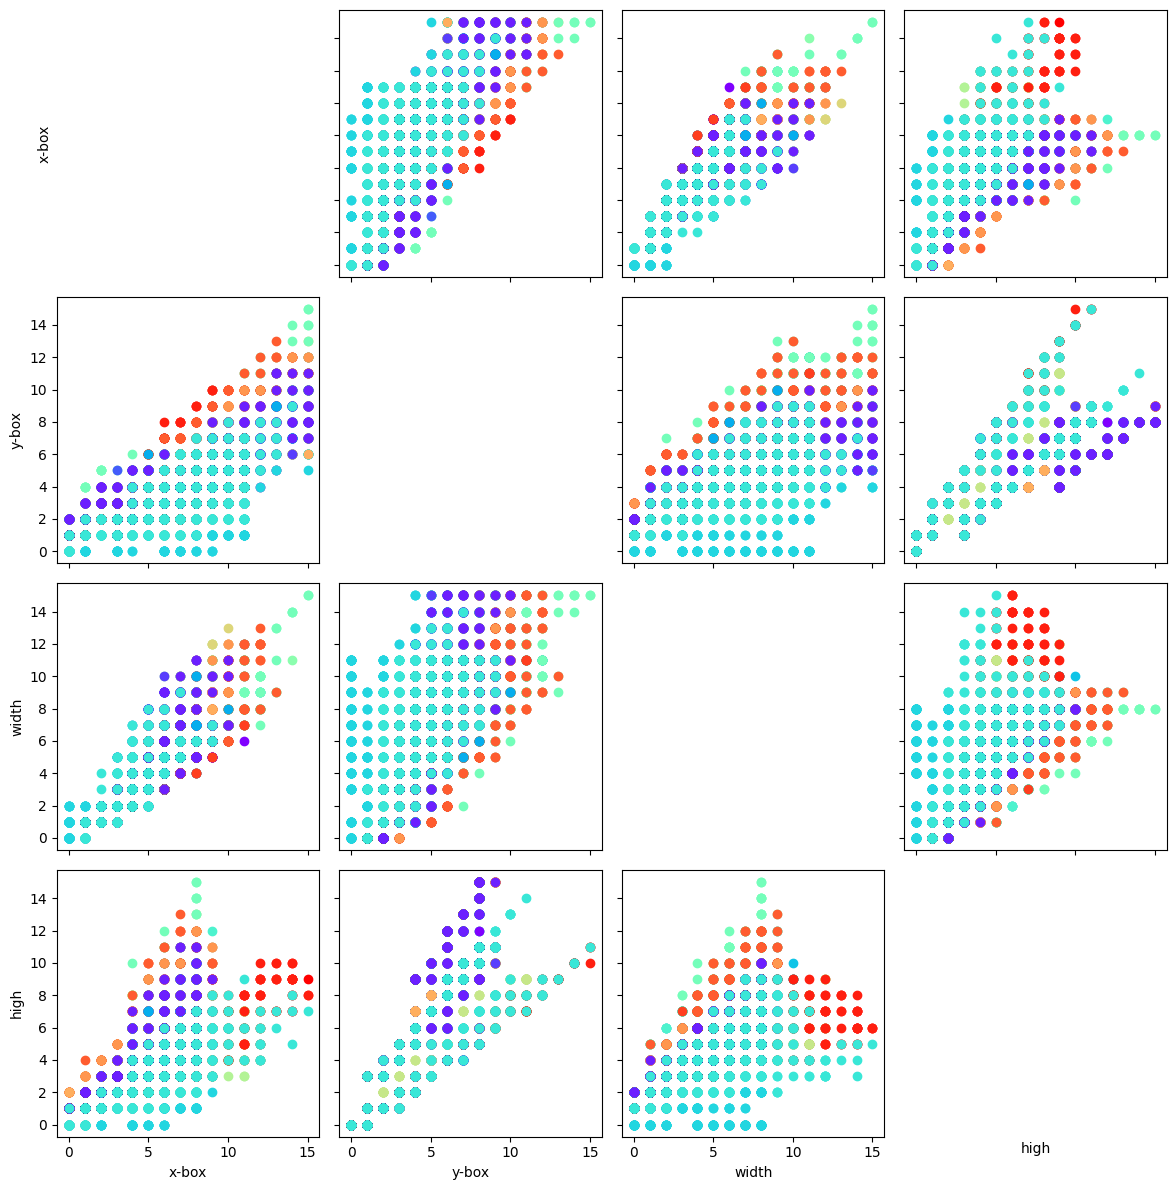

In [6]:
label_map = {}
for i in range(26):
  label_map[i] = chr(ord('A') + i)

data = arff.loadarff('letters.arff')

df = pd.DataFrame(data[0])
df.letter = df.letter.map(lambda x: chr(x[0]))

# pair_plot(df, df.columns, 'letter')
pair_plot(df, ['x-box', 'y-box', 'width', 'high'], 'letter')


labels = df.letter
df.drop(columns=['letter'], inplace=True)

In [8]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
print(device)

cuda


In [10]:
training_data = df.sample(frac=0.75)
training_labels = pd.get_dummies(labels[training_data.index])
testing_data = df.drop(training_data.index)
testing_labels = pd.get_dummies(labels.drop(training_labels.index))

training_data = np.array(training_data)
training_labels = np.array(training_labels)
testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)

training_data = torch.tensor(training_data.astype(np.float32))
training_labels = torch.tensor(training_labels.astype(np.float32))
testing_data = torch.tensor(testing_data.astype(np.float32))
testing_labels = torch.tensor(testing_labels.astype(np.float32))

training_loader = DataLoader(torch.utils.data.TensorDataset(training_data, training_labels), batch_size=64, shuffle=True)

network = PytorchNeuralNetork(16, 26, 2)
network.to(device)

network.train_model(device, training_loader, nn.MSELoss(), optim.SGD(network.parameters(), lr=.1, momentum=0.9), verbosity=100, epochs=500)

print(network.test_accuracy(device, testing_data, testing_labels)) # This was decided arbitrarily, hyperparameter tuning comes next

Epoch 0: Loss 0.03710456192493439
Epoch 100: Loss 0.00780284870415926
Epoch 200: Loss 0.00844999123364687
Epoch 300: Loss 0.004721096716821194
Epoch 400: Loss 0.0025047094095498323
{'type': 'multiclass_classification', 'accuracy': 0.8727999925613403, 'num_correct': 4364, 'total_samples': 5000}


In [11]:
alpha = [0.001, 0.01, 0.1]
batch_size = [32, 64, 128]
momentum = [0.5, 0.9, 0.99]
hidden_layers = [0, 1, 2]

best_accuracy = 0
best_hypers = None
for a in alpha:
  for m in momentum:
    for h in hidden_layers:
      for b in batch_size:
        network = PytorchNeuralNetork(16, 26, h)
        network.to(device)
        training_loader = DataLoader(torch.utils.data.TensorDataset(training_data, training_labels), batch_size=b, shuffle=True)
        network.train_model(device, training_loader, nn.MSELoss(), optim.SGD(network.parameters(), lr=a, momentum=m), verbosity=None, epochs=150)

        accuracy = network.test_accuracy(device, testing_data, testing_labels)
        if accuracy['accuracy'] > best_accuracy:
          best_accuracy = accuracy['accuracy']
          best_hypers = {
            'alpha': a,
            'momentum': m,
            'hidden_layers': h,
            'batch_size': b
          }
          print(f"New best accuracy: {best_accuracy} with {best_hypers}")
print()
print(f"Best accuracy: {best_accuracy} with {best_hypers}")

New best accuracy: 0.16040000319480896 with {'alpha': 0.001, 'momentum': 0.5, 'hidden_layers': 0, 'batch_size': 32}
New best accuracy: 0.3531999886035919 with {'alpha': 0.001, 'momentum': 0.9, 'hidden_layers': 0, 'batch_size': 32}
New best accuracy: 0.37379997968673706 with {'alpha': 0.001, 'momentum': 0.9, 'hidden_layers': 1, 'batch_size': 32}
New best accuracy: 0.6171999573707581 with {'alpha': 0.001, 'momentum': 0.99, 'hidden_layers': 0, 'batch_size': 32}
New best accuracy: 0.6299999952316284 with {'alpha': 0.001, 'momentum': 0.99, 'hidden_layers': 0, 'batch_size': 64}
New best accuracy: 0.7626000046730042 with {'alpha': 0.001, 'momentum': 0.99, 'hidden_layers': 1, 'batch_size': 32}
New best accuracy: 0.7799999713897705 with {'alpha': 0.01, 'momentum': 0.9, 'hidden_layers': 2, 'batch_size': 32}
New best accuracy: 0.8203999996185303 with {'alpha': 0.01, 'momentum': 0.99, 'hidden_layers': 1, 'batch_size': 32}
New best accuracy: 0.8423999547958374 with {'alpha': 0.01, 'momentum': 0.99,

I learned to use pytorch using the beginner tutorial and the docs. Linked below (I don't remember every page I used, so I just linked the hub for beginner stuff).

https://docs.pytorch.org/tutorials/beginner/basics

I decided on a momentum based optimizer, not for any particularly great reason. I like that it smooths out the differences between batches of training data. It causes some osscilation at higher epoch counts, but I can deal with that.

I decided to tune along learning rate, momentum, batch size and hidden layer count using a grid search. Again, there was no particular reason for the choice of those four other than they seemed interesting. Tuning around epoch count might yield some sort of interesting result, but I figured it would just be higher=better, so I didn't.

I decided on 150 epochs because it seemed like 500 (as in the arbitrary example) would have taken too long to run. Even with the T4 provided by Colab, the example above took an hour and a half to run